# **Time Series With LSTM**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('/monthly_milk_production.csv',index_col='Date',parse_dates=True) # making date column an index
df.index.freq='MS' # making date column an index and us ma bhi month ko

In [4]:
df

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727
...,...
1975-08-01,858
1975-09-01,817
1975-10-01,827


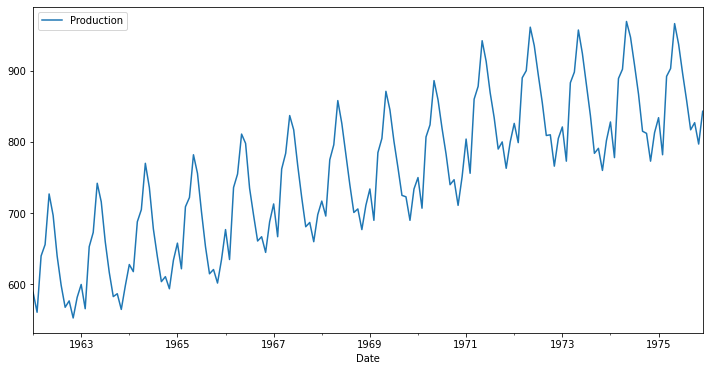

In [5]:
df.plot(figsize=(12,6))

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose # returns a result object. The result object contains arrays to access four pieces of data from the decomposition

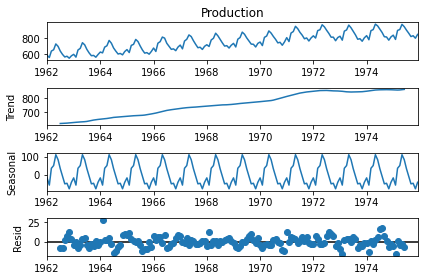

In [10]:
results = seasonal_decompose(df['Production'])
results.plot();

In [11]:
len(df)

168

In [12]:
168-12

156

In [13]:
train = df.iloc[:156]
test = df.iloc[156:] # alst  12 for testing 

In [14]:
from sklearn.preprocessing import MinMaxScaler # preserves the shape of the original distribution.
scaler = MinMaxScaler()

In [15]:
df.head()

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


In [16]:
scaler.fit(train)
scaled_train = scaler.transform(train)  #used on training data to scale the data and also learn the scaling parameters.Scaling. This means that you're transforming your data so that it fits within a specific scale
scaled_test = scaler.transform(test)

In [17]:
scaled_train[:10]

array([[0.08653846],
       [0.01923077],
       [0.20913462],
       [0.24759615],
       [0.41826923],
       [0.34615385],
       [0.20913462],
       [0.11057692],
       [0.03605769],
       [0.05769231]])

In [18]:
from keras.preprocessing.sequence import TimeseriesGenerator #Once a TimeseriesGenerator instance has been defined, it can be used to train a neural network model. A model can be trained using the TimeseriesGenerator as a data generator.

In [20]:
#123 4 --> 345 --> 456 --> 567 --> 567 

In [25]:
# define generator
n_input = 3 #picking 3 bacthes at a time to predict the next batch
n_features = 1 # because we only have one featyer that is production
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [26]:
X,y = generator[2] # skip first 2 and then pick next 3 cell 17
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.20913462 0.24759615 0.41826923]
Predict this y: 
 [[0.34615385]]


In [27]:
# We do the same thing, but now instead for 12 months
n_input = 12 # using 12 months data to predict 13th one
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [28]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [30]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features))) #100 nurons, n_inpu as give above 12,transforming the summed weighted input from the node into the activation of the node or output for that input
model.add(Dense(1)) # last layer, one output
model.compile(optimizer='adam', loss='mse')

In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               40800     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [32]:
# fit model
model.fit(generator,epochs=50) #indicates the number of passes of the entire training dataset the machine learning algorithm has completed.

Epoch 1/50
144/144 [==============================] - 4s 9ms/step - loss: 0.0440
Epoch 2/50
144/144 [==============================] - 1s 9ms/step - loss: 0.0196
Epoch 3/50
144/144 [==============================] - 1s 9ms/step - loss: 0.0187
Epoch 4/50
144/144 [==============================] - 1s 8ms/step - loss: 0.0097
Epoch 5/50
144/144 [==============================] - 1s 9ms/step - loss: 0.0071
Epoch 6/50
144/144 [==============================] - 1s 9ms/step - loss: 0.0055
Epoch 7/50
144/144 [==============================] - 1s 8ms/step - loss: 0.0046
Epoch 8/50
144/144 [==============================] - 1s 8ms/step - loss: 0.0034
Epoch 9/50
144/144 [==============================] - 1s 8ms/step - loss: 0.0064
Epoch 10/50
144/144 [==============================] - 1s 8ms/step - loss: 0.0055
Epoch 11/50
144/144 [==============================] - 1s 7ms/step - loss: 0.0036
Epoch 12/50
144/144 [==============================] - 1s 8ms/step - loss: 0.0044
Epoch 13/50
144/144 [====

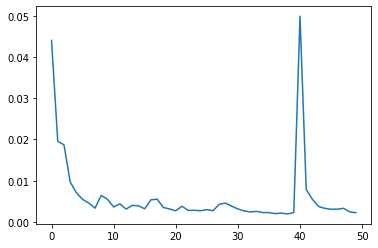

In [33]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

#Make Predictions with LSTM

In [34]:
last_train_batch = scaled_train[-12:] #Using the last 12 months data

In [39]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [42]:
model.predict(last_train_batch) # as it is time serties data so you can not predict the exactly

array([[0.71615005]], dtype=float32)

In [41]:
scaled_test[0]

array([0.67548077])

In [43]:
test_predictions = []

first_eval_batch = scaled_train[-12:] # last 12 values
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [44]:
test_predictions

[array([0.71615005], dtype=float32),
 array([0.6314752], dtype=float32),
 array([0.88835233], dtype=float32),
 array([0.94478995], dtype=float32),
 array([1.0706568], dtype=float32),
 array([1.0366246], dtype=float32),
 array([0.952251], dtype=float32),
 array([0.85662764], dtype=float32),
 array([0.72367007], dtype=float32),
 array([0.69971144], dtype=float32),
 array([0.6182149], dtype=float32),
 array([0.6946733], dtype=float32)]

In [45]:
test.head()

,Production
Date,
1975-01-01,834
1975-02-01,782
1975-03-01,892
1975-04-01,903
1975-05-01,966


In [46]:
true_predictions = scaler.inverse_transform(test_predictions)

In [47]:
test['Predictions'] = true_predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [48]:
test.tail()

,Production,Predictions
Date,,
1975-08-01,858,909.357100
1975-09-01,817,854.046747
1975-10-01,827,844.079960
1975-11-01,797,810.177401
1975-12-01,843,841.984093


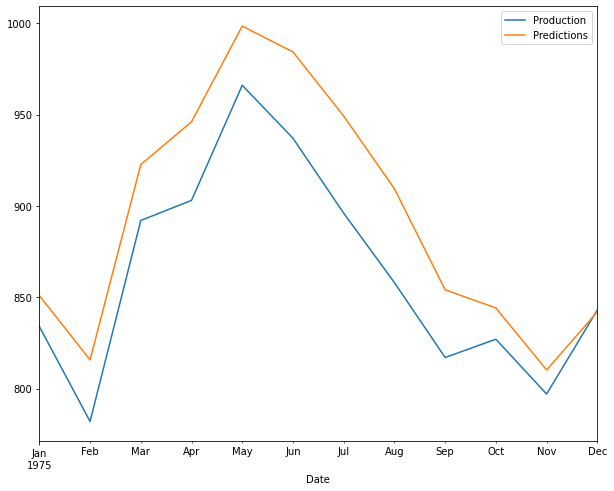

In [49]:
test.plot(figsize=(10,8))

In [50]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['Production'],test['Predictions']))
print(rmse)

35.10380052898825
